# Merged model evaluation

In [29]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.functional_profiles as fp
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from scipy import stats
import glob
import numpy as np




In [30]:
files = sorted(
    glob.glob(f'{ut.model_dir}//Models/Evaluation/nettekoven_68/eval_*'))

list_of_dfs = []
for f, file in enumerate(files):
    t = pd.read_csv(file, delimiter='\t')
    list_of_dfs.append(t)
    t['source'] = file.split('/')[-1].strip('.tsv')

D = pd.concat(list_of_dfs, ignore_index=True).reset_index(drop=True)
D.drop_duplicates(subset=D.columns.difference(['source']))

D.shape

(8942, 15)

In [31]:
crits = ['dcbc_group','dcbc_indiv']

# recover info
for r,row in D.iterrows():
    print(r, row.source)
    new = fp.recover_info(row, info_type='evaluation_info')
    # print(r, new.train_data)
    D.iloc[r] = new
                    

figsize = (10,10)
# Determine origin of model: clustered_in_C3 (and then refitted to C2), clustered (on C2 or C3 data, but not refitted to another space), data (pure data-driven model)
for r,row in D.iterrows():
    if row['atlas'] == 'MNISymC2':
        if 'fromC3' in row['source']:
            D.loc[r,'origin'] = 'clustered_in_C3'
        elif 'mixed' in row['source']:
            D.loc[r,'origin'] = 'clustered'
        else:
            D.loc[r,'origin'] = 'data'
    elif row['atlas'] == 'MNISymC3':
        if 'mixed' in row['source']:
            D.loc[r,'origin'] = 'clustered'
        else:
            D.loc[r,'origin'] = 'data'

# Determine whether model was trained on rest, task and rest, or task only
for r,row in D.iterrows():
    if ['HCP'] == row['train_data']:
        D.loc[r, 'trained_on'] = 'rest'
    elif 'HCP' in row['train_data']:
        D.loc[r, 'trained_on'] = 'task_and_rest'
    else:
        D.loc[r, 'trained_on'] = 'task'
        

# Determine whether model was tested on rest, task and rest, or task only
for r, row in D.iterrows():
    if 'HCP' == row['test_data']:
        D.loc[r, 'tested_on'] = 'rest'
    else:
        D.loc[r, 'tested_on'] = 'task'

# Leave-one-out / All / Individual indicator
for r, row in D.iterrows():
    n_train_datasets = len(row['train_data'])
    if n_train_datasets==1:
        D['train_type'] = 'indiv'
    elif n_train_datasets==6:
        D['train_type'] = 'loo'
    elif n_train_datasets==7:
        if 'HCP' in row['train_data']:
            D['train_type'] = 'loo'
        else:
            D['train_type'] = 'all'
    elif n_train_datasets==8:
        D['train_type'] = 'all'

# Symmetric / Asymmetric indicator
for r, row in D.iterrows():
    if 'sym' in row['source']:  
        D.loc[r, 'symmetry'] = 'symmetric'
    else:
        D.loc[r, 'symmetry'] = 'asymmetric'


# Cross-validation indicator
for r, row in D.iterrows():
    train_test_match = [data in row.test_data for data in row.train_data]
    if np.any(train_test_match):
        D.loc[r, 'cv'] = False
    else:
        D.loc[r, 'cv'] = True

D.tail()


0 eval_on-rest_sym_Hc_space-MNISymC3_K-10
1 eval_on-rest_sym_Hc_space-MNISymC3_K-10
2 eval_on-rest_sym_Hc_space-MNISymC3_K-10
3 eval_on-rest_sym_Hc_space-MNISymC3_K-10
4 eval_on-rest_sym_Hc_space-MNISymC3_K-10
5 eval_on-rest_sym_Hc_space-MNISymC3_K-10
6 eval_on-rest_sym_Hc_space-MNISymC3_K-10
7 eval_on-rest_sym_Hc_space-MNISymC3_K-10
8 eval_on-rest_sym_Hc_space-MNISymC3_K-10
9 eval_on-rest_sym_Hc_space-MNISymC3_K-10
10 eval_on-rest_sym_Hc_space-MNISymC3_K-10
11 eval_on-rest_sym_Hc_space-MNISymC3_K-10
12 eval_on-rest_sym_Hc_space-MNISymC3_K-10
13 eval_on-rest_sym_Hc_space-MNISymC3_K-10
14 eval_on-rest_sym_Hc_space-MNISymC3_K-10
15 eval_on-rest_sym_Hc_space-MNISymC3_K-10
16 eval_on-rest_sym_Hc_space-MNISymC3_K-10
17 eval_on-rest_sym_Hc_space-MNISymC3_K-10
18 eval_on-rest_sym_Hc_space-MNISymC3_K-10
19 eval_on-rest_sym_Hc_space-MNISymC3_K-10
20 eval_on-rest_sym_Hc_space-MNISymC3_K-10
21 eval_on-rest_sym_Hc_space-MNISymC3_K-10
22 eval_on-rest_sym_Hc_space-MNISymC3_K-10
23 eval_on-rest_sym_H

,model_name,atlas,K,train_data,train_loglik,subj_num,common_kappa,dcbc_group,dcbc_indiv,model_type,...,indivtrain_ind,indivtrain_val,test_data,source,origin,trained_on,tested_on,train_type,symmetry,cv
8937,sym_MdPoNiIbWmDeSo,MNISymC2,32,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",64498792.0,95,True,0.083549,0.142998,Models_03,...,half,2,HCP,eval_sym_MdPoNiIbWmDeSo_space-MNISymC2_K-32_me...,clustered,task,rest,all,symmetric,True
8938,sym_MdPoNiIbWmDeSo,MNISymC2,32,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",64498792.0,96,True,0.072170,0.081665,Models_03,...,half,2,HCP,eval_sym_MdPoNiIbWmDeSo_space-MNISymC2_K-32_me...,clustered,task,rest,all,symmetric,True
8939,sym_MdPoNiIbWmDeSo,MNISymC2,32,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",64498792.0,97,True,0.076484,0.128629,Models_03,...,half,2,HCP,eval_sym_MdPoNiIbWmDeSo_space-MNISymC2_K-32_me...,clustered,task,rest,all,symmetric,True
8940,sym_MdPoNiIbWmDeSo,MNISymC2,32,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",64498792.0,98,True,0.145713,0.256534,Models_03,...,half,2,HCP,eval_sym_MdPoNiIbWmDeSo_space-MNISymC2_K-32_me...,clustered,task,rest,all,symmetric,True
8941,sym_MdPoNiIbWmDeSo,MNISymC2,32,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",64498792.0,99,True,0.090234,0.195431,Models_03,...,half,2,HCP,eval_sym_MdPoNiIbWmDeSo_space-MNISymC2_K-32_me...,clustered,task,rest,all,symmetric,True


In [32]:
D[(D.train_type=='loo') & (D.cv == False)]

,model_name,atlas,K,train_data,train_loglik,subj_num,common_kappa,dcbc_group,dcbc_indiv,model_type,...,indivtrain_ind,indivtrain_val,test_data,source,origin,trained_on,tested_on,train_type,symmetry,cv


In [33]:

np.any(D.train_type=='loo')
# D[(D.tested_on=='task') & (D.trained_on=='task')]

False

### Comparing clustered, clustered in C3 and data-driven parcellations for K=32

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_19787/3182203188.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  D[(D.train_type == 'all') & (D.K == 32)].groupby(['atlas','origin']).mean()


K  train_loglik   subj_num  common_kappa  \
atlas    origin                                                         
MNISymC2 clustered        32.0  6.449879e+07  29.142180           1.0   
         clustered_in_C3  32.0  6.521779e+07  10.801802           1.0   
         data             32.0  6.532013e+07  10.801802           1.0   
MNISymC3 clustered        32.0  1.940202e+07  10.801802           1.0   
         data             32.0  1.055076e+08  19.739030           1.0   

                          dcbc_group  dcbc_indiv  indivtrain_val  
atlas    origin                                                   
MNISymC2 clustered          0.088675    0.156923             1.5  
         clustered_in_C3    0.106587    0.167769             1.5  
         data               0.101088    0.172838             1.5  
MNISymC3 clustered          0.093097    0.171512             1.5  
         data               0.101587    0.175062             1.5

<Figure size 1000x1000 with 0 Axes>

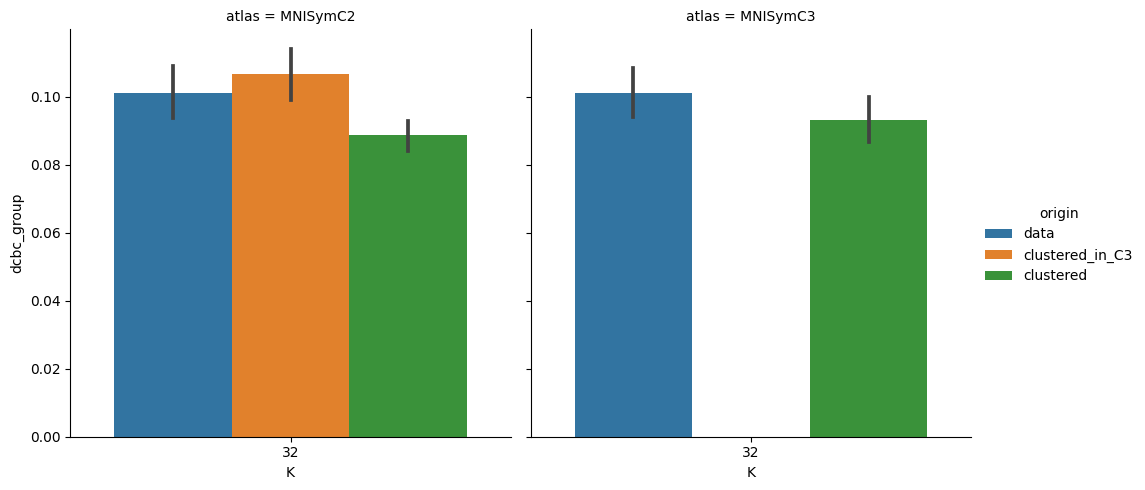

<Figure size 1000x1000 with 0 Axes>

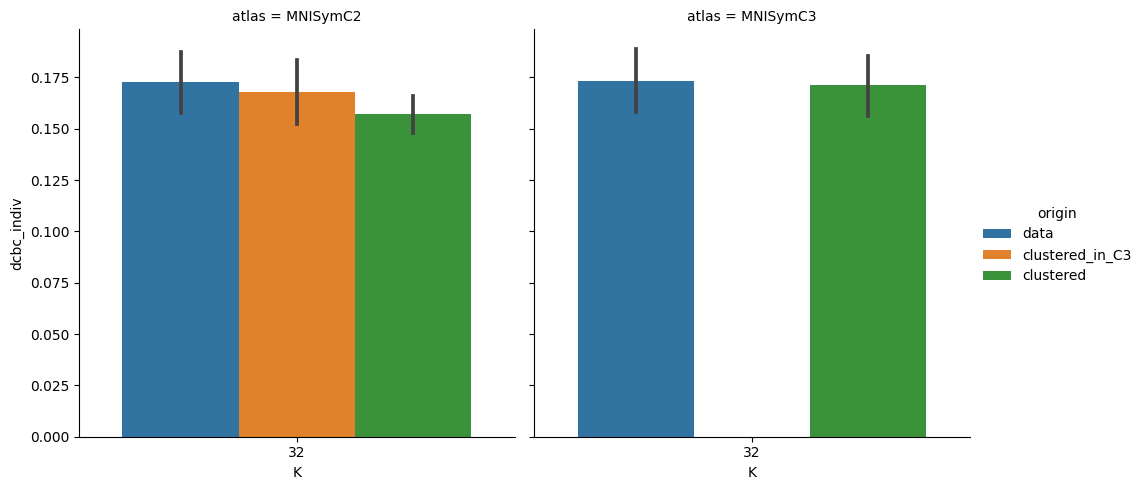

In [34]:

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.train_type == 'all') & (D.K == 32) & (D.trained_on == 'task')], x="K", y="dcbc_group", col="atlas", hue="origin", kind="bar")

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.train_type == 'all') & (D.K == 32) & (D.trained_on == 'task')], x="K", y="dcbc_indiv", col="atlas", hue="origin", kind="bar")

# Get mean of DCBC for each origin
D[(D.train_type == 'all') & (D.K == 32)].groupby(['atlas','origin']).mean()
# D[(D.train_type == 'all') & (D.K == 32)].groupby(['atlas','origin']).std()

### Comparing pure task-trained, rest-and-task-trained, and rest-trained parcellations

<Figure size 1000x1000 with 0 Axes>

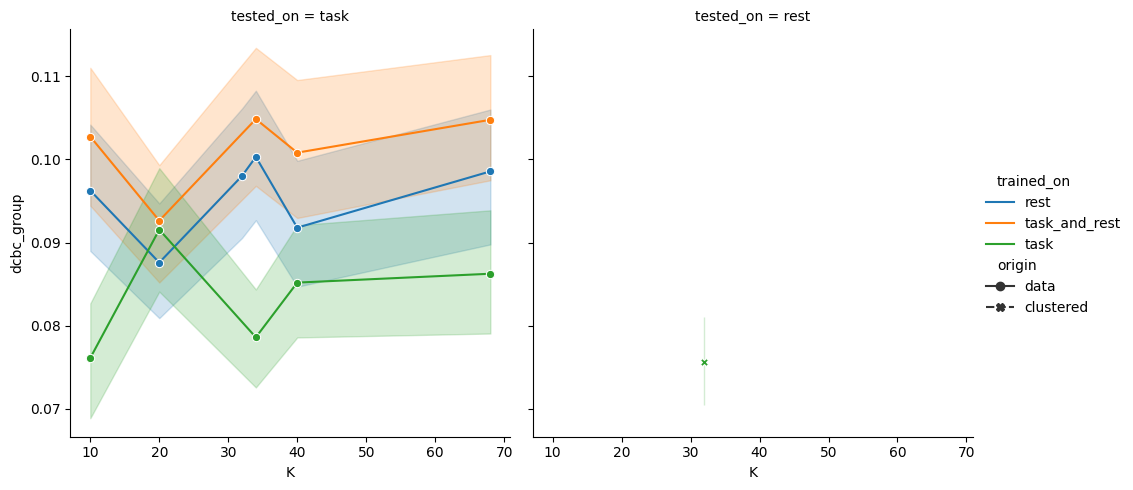

<Figure size 1000x1000 with 0 Axes>

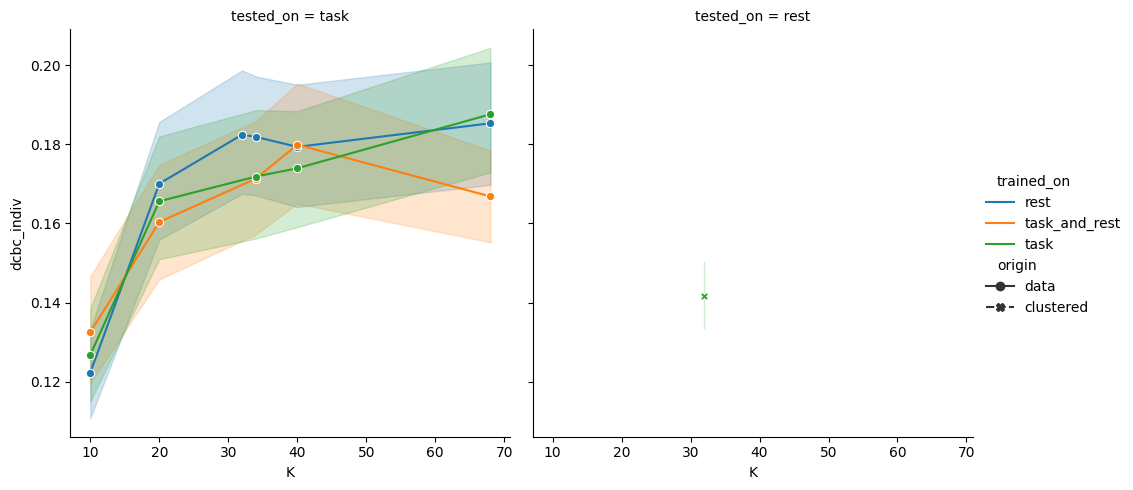

In [35]:

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv==True], x="K", y="dcbc_group", col="tested_on", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv == True], x="K", y="dcbc_indiv", col="tested_on", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)



<Figure size 1000x1000 with 0 Axes>

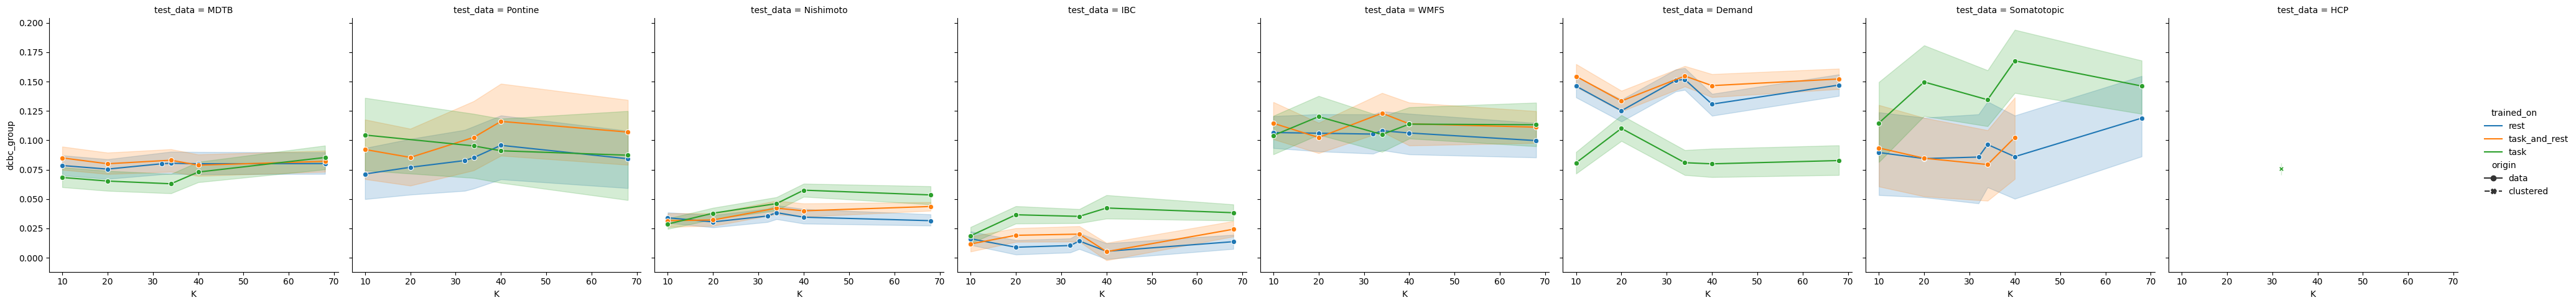

<Figure size 1000x1000 with 0 Axes>

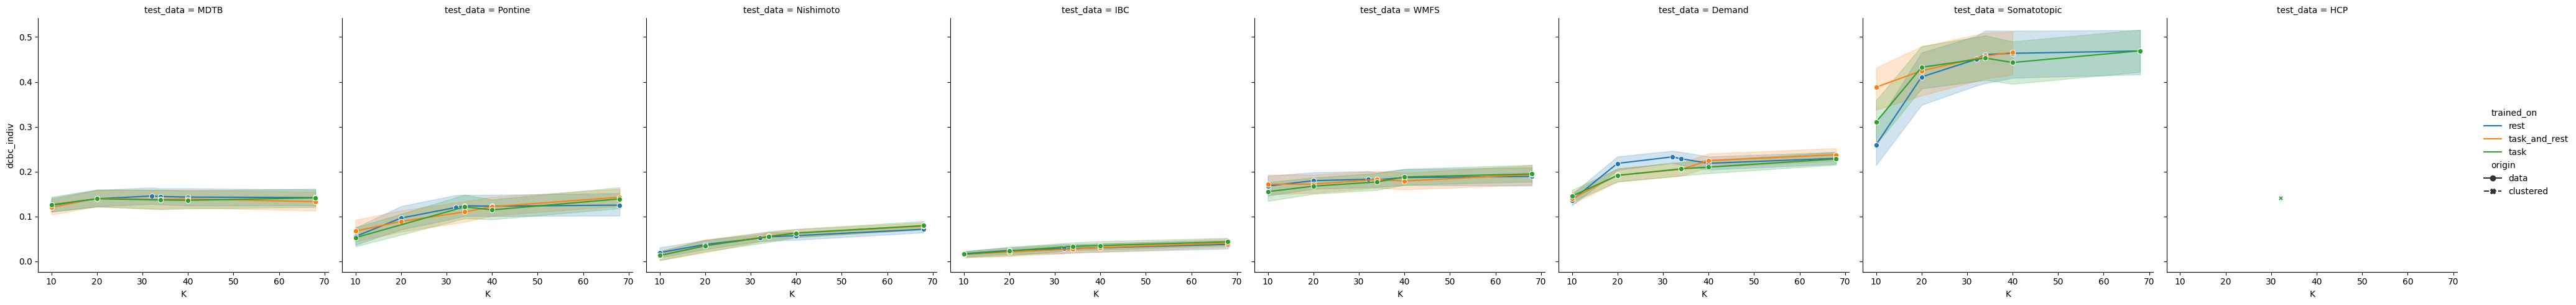

In [36]:

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv == True], x="K", y="dcbc_group", col="test_data", hue="trained_on", kind="line", style="origin", markers=True)

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv == True], x="K", y="dcbc_indiv", col="test_data", hue="trained_on", kind="line", style="origin", markers=True)


In [37]:
D[(D.cv==True) & (D.tested_on=='task')].tail()

,model_name,atlas,K,train_data,train_loglik,subj_num,common_kappa,dcbc_group,dcbc_indiv,model_type,...,indivtrain_ind,indivtrain_val,test_data,source,origin,trained_on,tested_on,train_type,symmetry,cv
8515,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,19,True,0.086474,0.166727,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,all,symmetric,True
8516,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,20,True,0.090322,0.140934,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,all,symmetric,True
8517,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,21,True,0.068447,0.096636,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,all,symmetric,True
8518,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,22,True,0.022585,0.136564,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,all,symmetric,True
8519,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,23,True,0.085314,0.137191,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,all,symmetric,True


<Figure size 1000x1000 with 0 Axes>

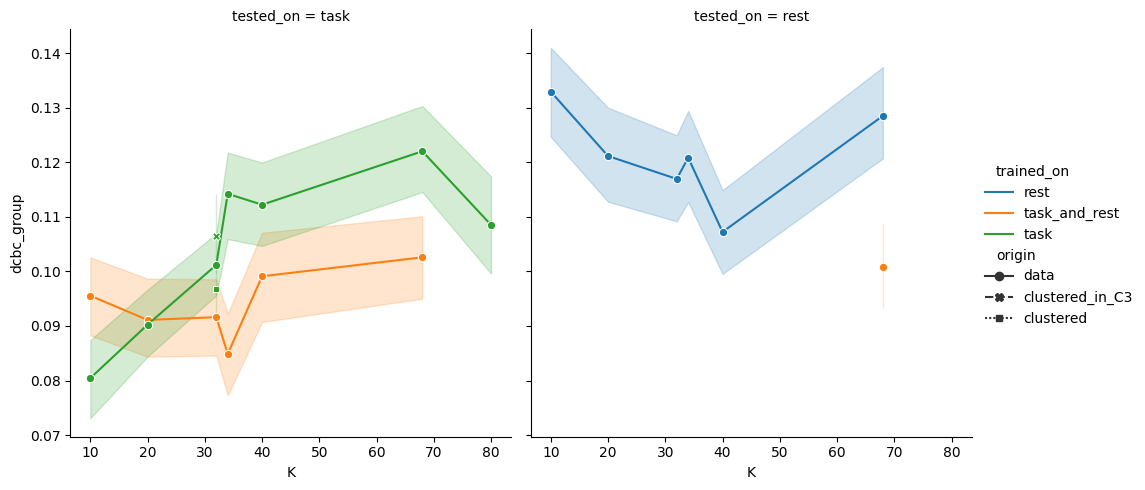

<Figure size 1000x1000 with 0 Axes>

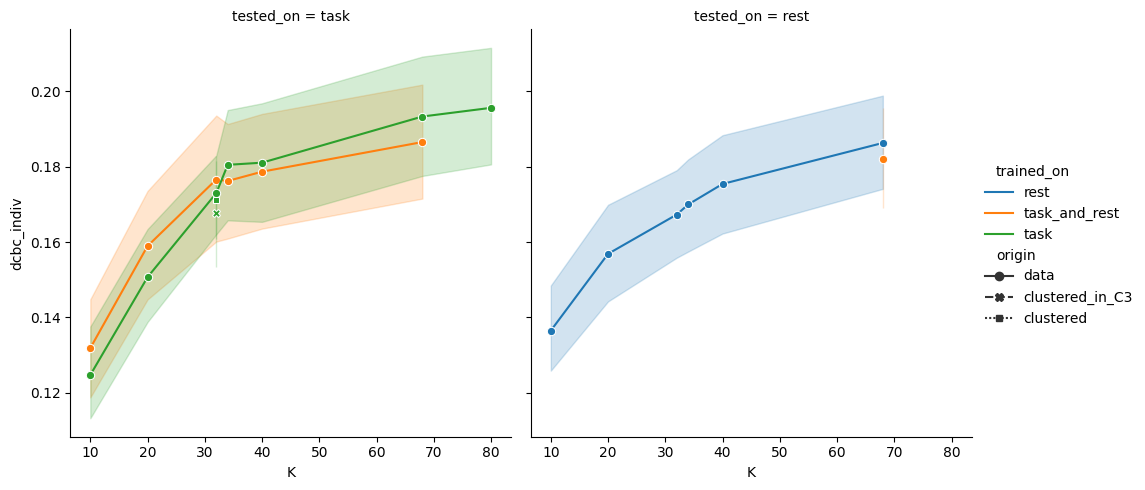

In [38]:

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv == False], x="K", y="dcbc_group", col="tested_on", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv == False], x="K", y="dcbc_indiv", col="tested_on", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)


<Figure size 1000x1000 with 0 Axes>

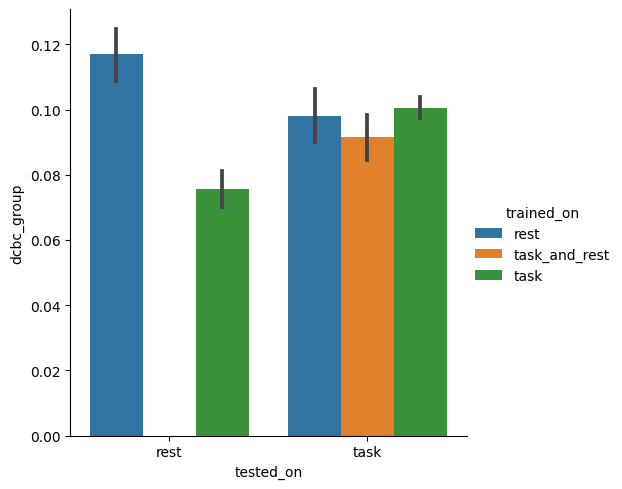

<Figure size 1000x1000 with 0 Axes>

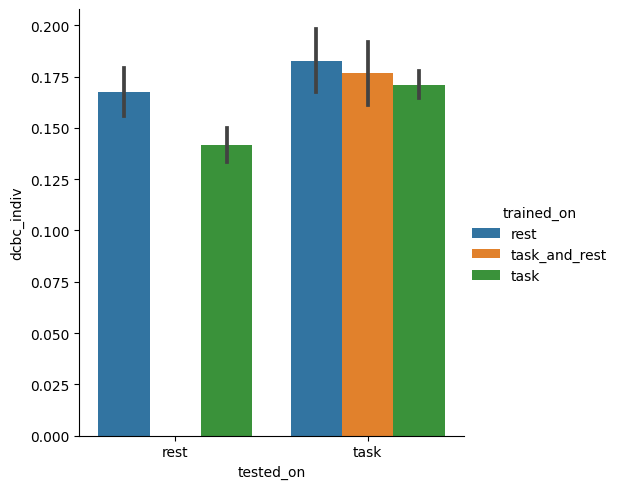

<Figure size 1000x1000 with 0 Axes>

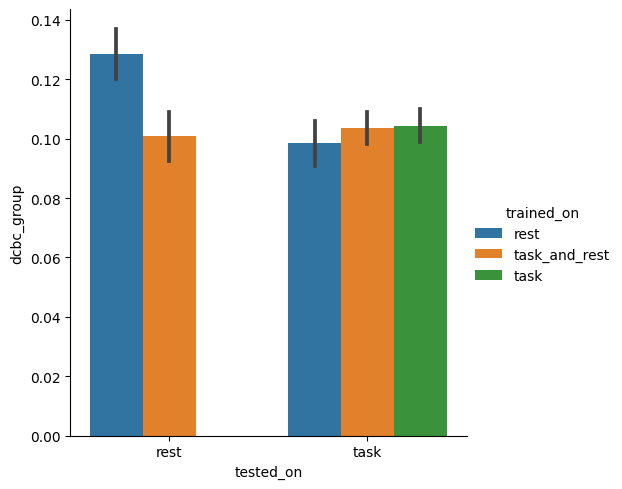

<Figure size 1000x1000 with 0 Axes>

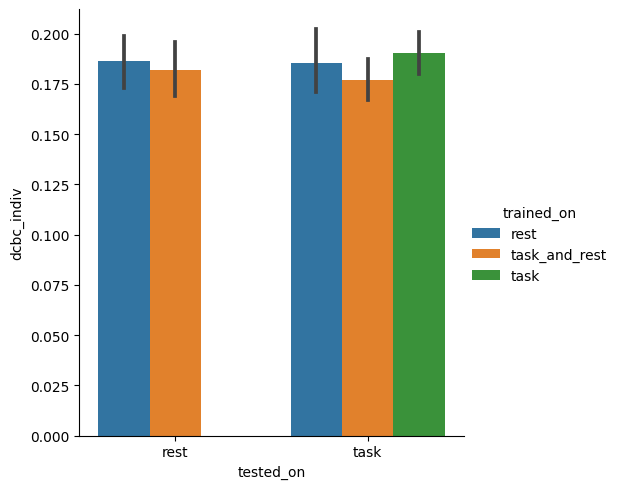

In [39]:

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.K == 32)], x="tested_on", y="dcbc_group", hue="trained_on", kind="bar")

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.K == 32)], x="tested_on", y="dcbc_indiv", hue="trained_on", kind="bar")

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.K == 68)], x="tested_on", y="dcbc_group", hue="trained_on", kind="bar")

plt.figure(figsize=figsize)
sb.catplot(
    data=D[(D.K == 68)], x="tested_on", y="dcbc_indiv", hue="trained_on", kind="bar")


### Comparing merged K 32 and data-derived K 34